In [85]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.utils import resample

import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import Compose, Normalize, ToTensor, Grayscale
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter

import torch.nn as nn
import torch.nn.functional as F

In [86]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")

Using cuda device


In [87]:
batch_size = 20

## Load data

In [88]:
#Define a transform object that takes the data to pytorch tensor form and normalizes it
###transform = Compose( [Grayscale(num_output_channels=1), ToTensor(), Normalize(mean=(0.5,),std=(0.5,))] );
transform = Compose( [ToTensor(), Normalize(mean=(0.5,),std=(0.5,))] );

In [89]:
dataset = ImageFolder('./splitted',transform=transform)

In [90]:
#dir(data)

In [91]:
#Imbalance
targets = dataset.targets
np.sum(targets) / len(targets)

0.2561538461538462

Due to the large imbalance, either the batch size has to be quite large in order to contain some positive examples, or we have to under- or over-sample the data. 

## Split data

In [92]:
#Get the indexes of the splitted data
train_idx, val_idx = train_test_split(np.arange(len(targets)), stratify=targets, test_size=0.2, random_state=123)

In [93]:
print("train size: {0}, validation_size: {1}".format(len(train_idx), len(val_idx)) )

train size: 13520, validation_size: 3380


In [94]:
#Imbalance
tr = [targets[i] for i in train_idx]
np.sum(tr) / len(tr)

0.25613905325443787

In [95]:
#Create samplers with the indexes for the dataloader to use
training_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(val_idx)

In [96]:
#Prepare batches that update at every epoch for training. Use multiprocessing
training_loader = DataLoader(dataset, batch_size=batch_size, sampler=training_sampler, num_workers=4)
validation_loader = DataLoader(dataset, batch_size=batch_size, sampler=validation_sampler, num_workers=4)

## Visualize

torch.Size([20, 3, 48, 48])


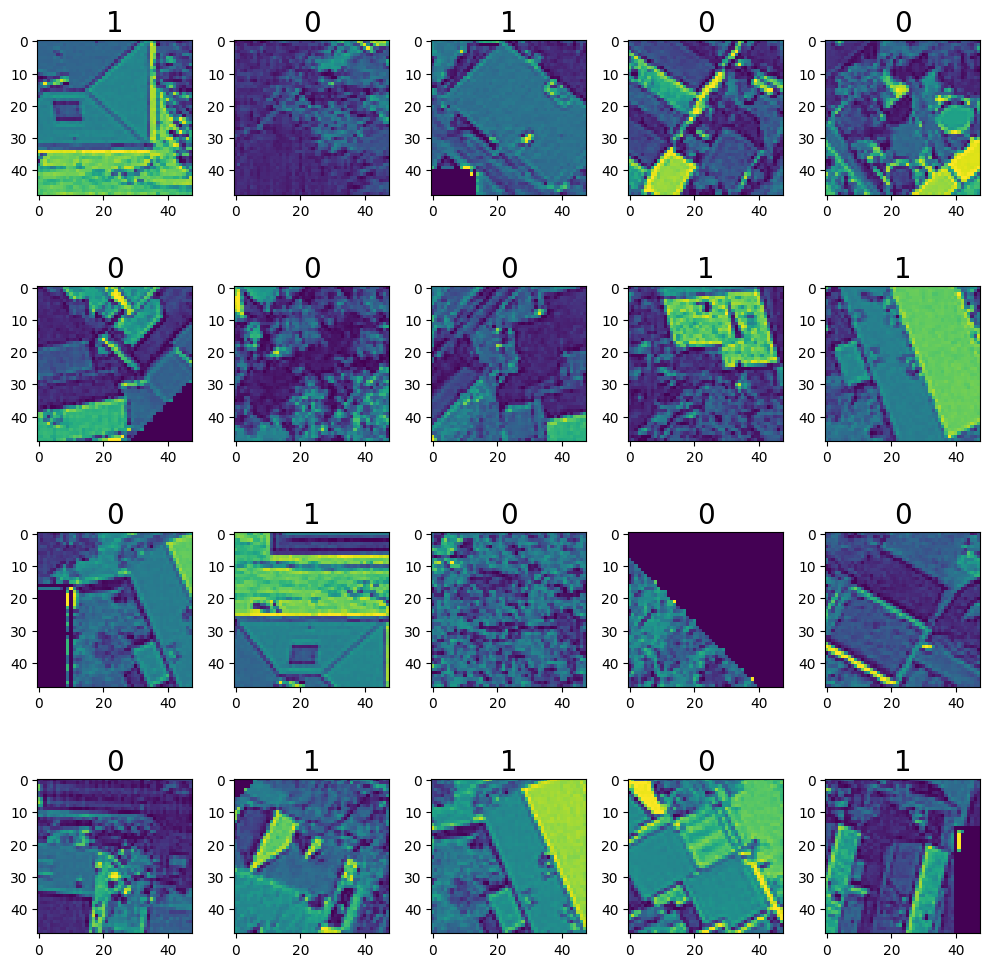

In [97]:
width = 5
heigth = int(np.ceil(batch_size / width))
it_trn = iter(training_loader)
fig0, ax = plt.subplots(heigth,width,figsize=(10, 10))
imgs, label = next(it_trn)
print(imgs.shape)
for j in range(heigth):
    for i in range(width):
        ax[j,i].imshow(imgs[j*width+i][0])#, cmap='gray')
        ax[j,i].set_title(int(label[j*width+i]), fontsize=20)
plt.tight_layout()

## The model

In [98]:
#pytorch models inherit from torch.nn.Module
class RooftopClassifier(nn.Module):
    def __init__(self):
        super(RooftopClassifier, self).__init__()
        #self.conv1 = nn.Conv2d(1, 6, 5, padding=2) #Add a convolution layer thet receives a single layer as imput (grayscale), uses 6 filters on it, and each filter has 5x5 size
        self.conv1 = nn.Conv2d(3, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=2)
        #self.pool1 = nn.MaxPool2d(2) #Pooling operation 4x4 kernel
        self.pool2 = nn.MaxPool2d(2) #Pooling operation 2x2 kernel
        self.line1 = nn.Linear(16*12*12, 120) #Add a lineal layer
        self.line2 = nn.Linear(120, 60)
        self.final = nn.Linear(60,2)
        self.relu = nn.ReLU() #Relu activation function
    
    def forward(self, x):
        x = self.conv1(x) #Apply convolution to the input
        x = self.relu(x)
        x = self.pool2(x) #Apply pooling to the first layer output
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = x.view(-1, 16*12*12)
        x = self.line1(x)
        x = self.relu(x)
        x = self.line2(x)
        x = self.relu(x)
        x = self.final(x)
        return x

In [99]:
model = RooftopClassifier().to(device)

## Loss function

In [100]:
## use the log loss as cost function
loss_fn = nn.CrossEntropyLoss()

## Optimizer

In [101]:
#Stochastic gradient descent optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=5.e-4, momentum=0.9)

## Training loop
- Get a batch of data from the Data Loader
- Zero the optimizer's gradients
- Gets predictions from the model for an imput batch
- Computes the loss function for the prediction
- Adjusts the model's weights with gradient descent
- Reports the loss for every xxx batches
- Reports the average per-batch loss for the last xxx batches for comparison to a validation run

In [102]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0
    last_loss = 0
    
    #Use an enumeration istead of an iterator to track the batch index and do reporting
    for i, data in enumerate(training_loader):
        #training instances are input + label pairs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        #zero the gradients
        optimizer.zero_grad()
        
        #make predictions fo this batch
        outputs = model(inputs)
        
        #compute loss and its gradient
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        #adjust the weights
        optimizer.step()
        
        #gather data and report
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100 #loss per batch
            print(' batch {} loss: {}'.format(i+1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0
            
        del inputs
        del labels
        torch.cuda.empty_cache()
            
    return last_loss

In [103]:
#train_one_epoch(0, None)

## Main loop
Before training an epoch there are a couple of things to do:
- Validate by checking the relative loss on a set of validation data and report it
- Save a copy of the model

We use TensorBoard to do the reporting.

In [104]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

In [105]:
epoch_number = 0
EPOCHS = 200
best_vloss = 1_000_000.
losslist = []
vlosslist = []

for epoch in range(EPOCHS):
    print('EPOCH {}'.format(epoch_number + 1))
    
    #Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)
    
    #To do reporting gradients do not need to be on
    model.train(False)
    
    #Pull batches fron validation data to validate
    running_vloss = 0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss
    
    avg_vloss = running_vloss / (i+1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    #losslist.append(avg_loss)
    #vlosslist.append(avg_vloss)
    
    ##Log the runnig loss averaged per batch for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                      {'Training': avg_loss, 'Validation': avg_vloss},
                      epoch_number + 1)
    writer.flush()
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)
        
    epoch_number += 1
    del vinputs
    del vlabels 
    torch.cuda.empty_cache()

EPOCH 1
 batch 100 loss: 0.6850417542457581
 batch 200 loss: 0.6396095156669617
 batch 300 loss: 0.6002957066893577
 batch 400 loss: 0.5834801417589187
 batch 500 loss: 0.5527058747410775
 batch 600 loss: 0.5445828413963318
LOSS train 0.5445828413963318 valid 0.5653187036514282
EPOCH 2
 batch 100 loss: 0.5736644622683525
 batch 200 loss: 0.5553548774123191
 batch 300 loss: 0.5638839694857597
 batch 400 loss: 0.5765144202113152
 batch 500 loss: 0.5386699399352074
 batch 600 loss: 0.5637589156627655
LOSS train 0.5637589156627655 valid 0.5577693581581116
EPOCH 3
 batch 100 loss: 0.5613868248462677
 batch 200 loss: 0.5548666653037071
 batch 300 loss: 0.5442975980043411
 batch 400 loss: 0.5534830951690674
 batch 500 loss: 0.548673503100872
 batch 600 loss: 0.529064749032259
LOSS train 0.529064749032259 valid 0.5358155965805054
EPOCH 4
 batch 100 loss: 0.5313076859712601
 batch 200 loss: 0.5258480533957481
 batch 300 loss: 0.5202797377109527
 batch 400 loss: 0.5135923969745636
 batch 500 los

 batch 100 loss: 0.29153890259563925
 batch 200 loss: 0.2944914522022009
 batch 300 loss: 0.300302864536643
 batch 400 loss: 0.27800544545054434
 batch 500 loss: 0.2874126747995615
 batch 600 loss: 0.3164347516000271
LOSS train 0.3164347516000271 valid 0.3175484538078308
EPOCH 31
 batch 100 loss: 0.29764908164739606
 batch 200 loss: 0.29950168885290623
 batch 300 loss: 0.2868307173252106
 batch 400 loss: 0.2858146499097347
 batch 500 loss: 0.2723277784883976
 batch 600 loss: 0.2993391051143408
LOSS train 0.2993391051143408 valid 0.30136772990226746
EPOCH 32
 batch 100 loss: 0.3095265226811171
 batch 200 loss: 0.290073788613081
 batch 300 loss: 0.26060363788157703
 batch 400 loss: 0.3034906093031168
 batch 500 loss: 0.27758744776248934
 batch 600 loss: 0.30202474027872084
LOSS train 0.30202474027872084 valid 0.38507896661758423
EPOCH 33
 batch 100 loss: 0.2807336290180683
 batch 200 loss: 0.26519110046327116
 batch 300 loss: 0.27630541391670704
 batch 400 loss: 0.29247425965964796
 batc

KeyboardInterrupt: 

In [ ]:
model.cpu() #return the model to the cpu

## Predict

In [106]:
#To load the saved version of the model
saved_model = RooftopClassifier()
saved_model.load_state_dict(torch.load('./_model_20220920_212757_43'))

<All keys matched successfully>

torch.Size([20, 3, 48, 48])


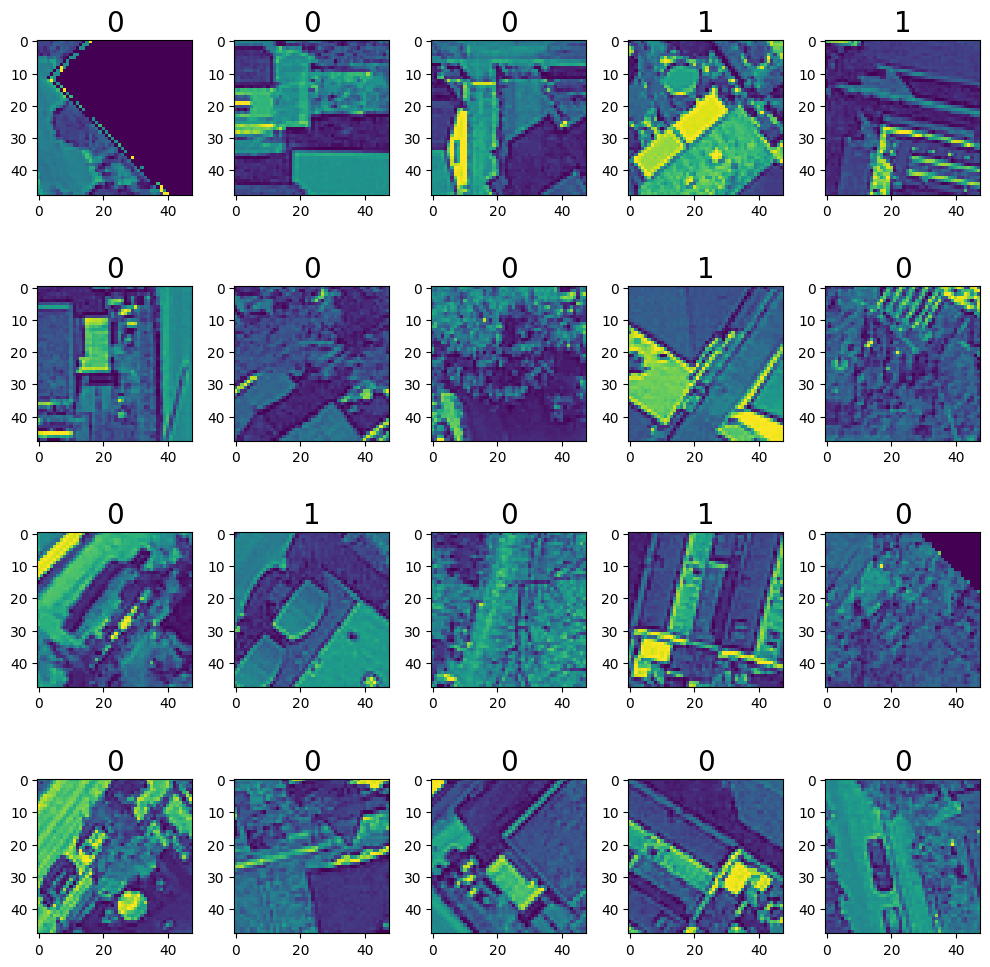

In [107]:
width = 5
heigth = int(np.ceil(batch_size / width))
it_trn = iter(validation_loader)
fig0, ax = plt.subplots(heigth,width,figsize=(10, 10))
imgs, label = next(it_trn)
print(imgs.shape)
for j in range(heigth):
    for i in range(width):
        ax[j,i].imshow(imgs[j*width+i][0])#, cmap='gray')
        ax[j,i].set_title(int(label[j*width+i]), fontsize=20)
plt.tight_layout()

In [108]:
out, idx = torch.max(saved_model(imgs), dim=1)
print(idx)
print(label)

tensor([0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0])
tensor([0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0])


torch.Size([20, 3, 48, 48])


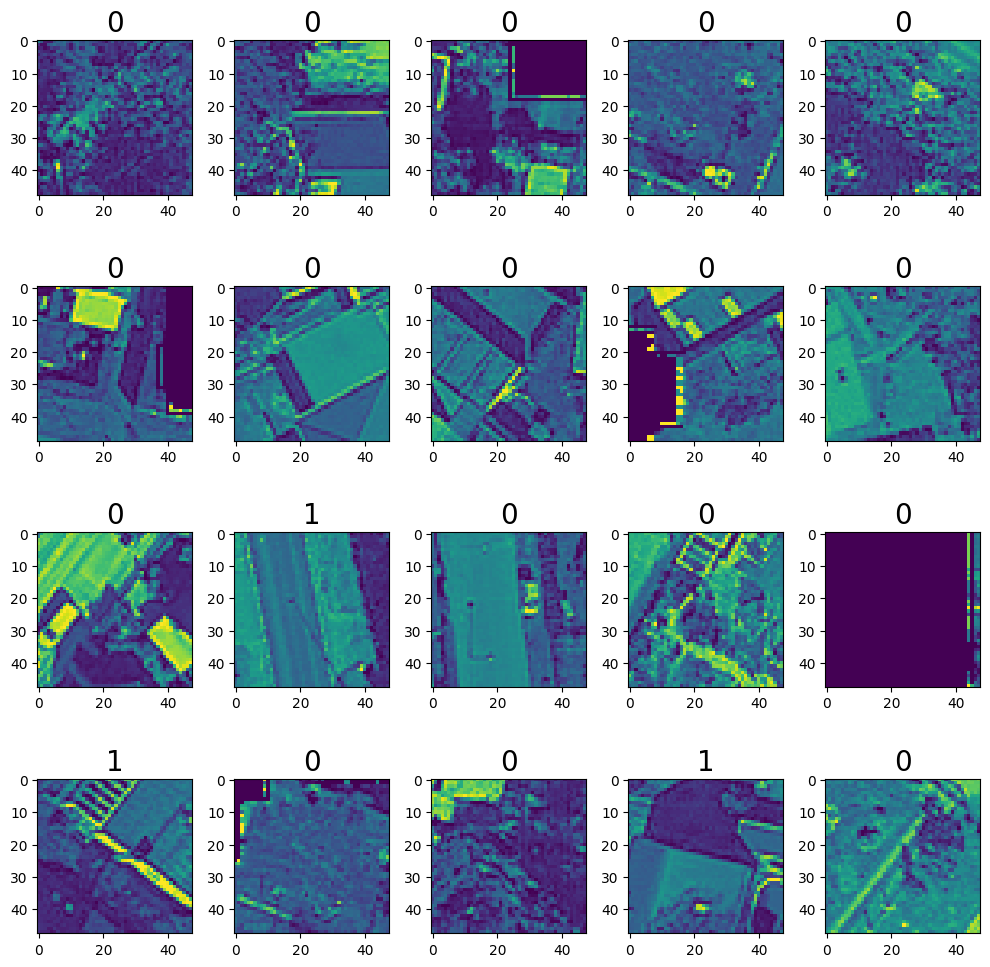

In [109]:
width = 5
heigth = int(np.ceil(batch_size / width))
fig0, ax = plt.subplots(heigth,width,figsize=(10, 10))
imgs, label = next(it_trn)
print(imgs.shape)
for j in range(heigth):
    for i in range(width):
        ax[j,i].imshow(imgs[j*width+i][0])#, cmap='gray')
        ax[j,i].set_title(int(label[j*width+i]), fontsize=20)
plt.tight_layout()

In [110]:
out, idx = torch.max(saved_model(imgs), dim=1)
print(idx)
print(label)

tensor([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0])
